# Visualization of difference matrices
This notebook illustrates the different ways to calculate the change between to Hi-C contact matrices. 

In [1]:
import sys
sys.path.insert(1, '/home/elinfi/MasterCode/clustering/class/')

In [2]:
import time
import numpy as np
import cooltools.lib.plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time
from k_medoids import KMedoids
from cluster_statistics import ClusterStatistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_preparation import DataPreparation
from dissimilarity_matrix import DissimilarityMatrix


In [3]:
# globally set font sizes
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In the comparison I use the merged wild type and cancer data. The Hi-C data is balanced using the built in ICE method in the cooler package. 

In [7]:
# get path to multi resolution hic data
path_wt = '/home/elinfi/coolers/HiC_wt_merged.mcool'
path_cancer = '/home/elinfi/coolers/HiC_cancer_merged.mcool'

resolution = 32000
#region = 'chr4:4M-10M' # region of genome
#region = 'chr19:13807597-16807597'
region = 'chr14:33408661-36408661'
balance = True

# create objects of class
wt = DataPreparation(path_wt, resolution, region, balance)
cancer = DataPreparation(path_cancer, resolution, region, balance)

# get the matrix size
print(f"Matrix size: {wt.matrix.shape}")

Matrix size: (94, 94)


To start with I plot the two created contact matrices for the given resolution and region.

# Her må det legges til riktig label på plottene

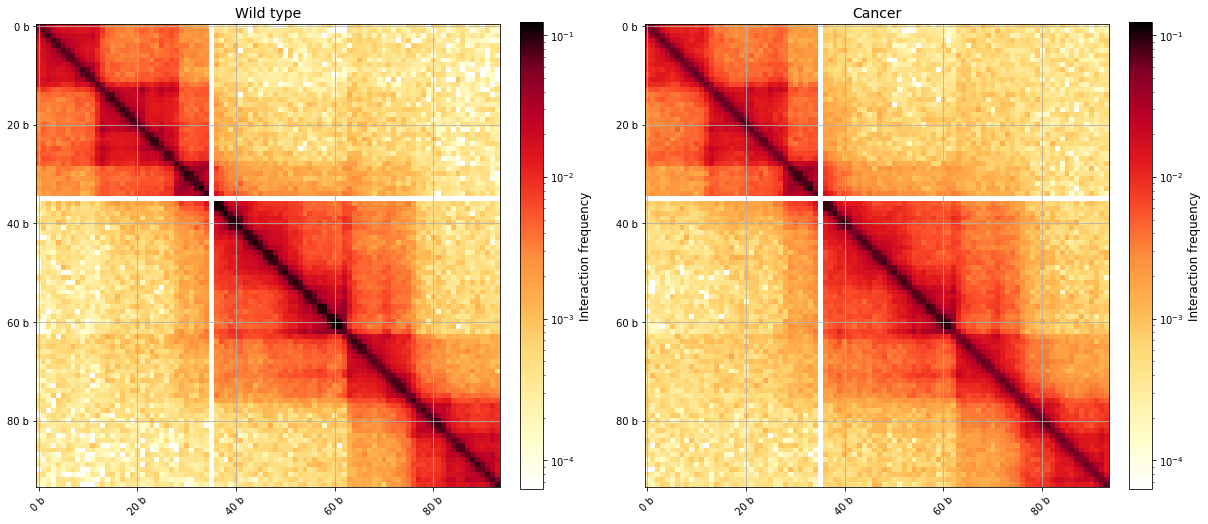

In [8]:
f, axs = plt.subplots(figsize=(20, 20),
                      nrows=1,
                      ncols=2,
                      sharex=True, sharey=False)

norm = mpl.colors.LogNorm()
#norm = None

ax = axs[0]
im = ax.matshow(wt.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Wild type')
format_ticks(ax)

ax = axs[1]
im = ax.matshow(cancer.matrix,
                norm=norm,
                cmap='fall',
                alpha=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interaction frequency', ax=ax)
ax.grid(b=True)
ax.set(title='Cancer')
format_ticks(ax)

## Subtraction
Calculate the difference between the two interaction matrices by subtraction and visualize it.

In [9]:
subtract_diff = wt.subtract(cancer)

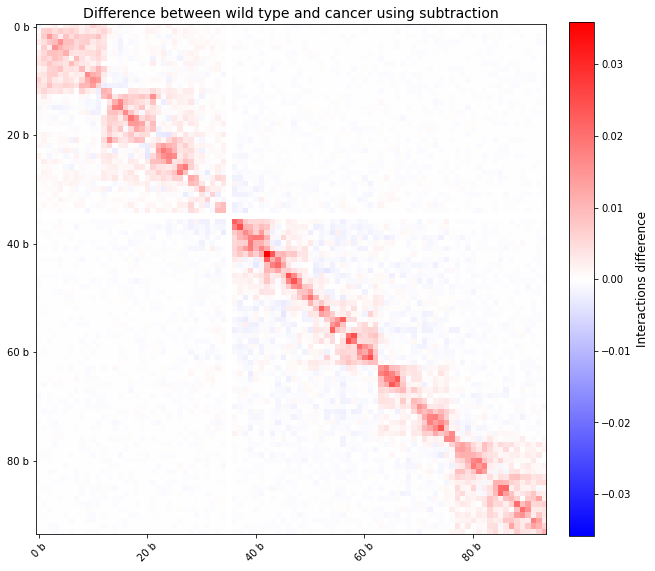

In [10]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(subtract_diff))
im = ax.matshow(subtract_diff,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title='Difference between wild type and cancer using subtraction')
plt.savefig('../../Figures/sub_002_001.png')
format_ticks(ax)

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.

## HiGlass divide by
Calculate the difference between the two interaction matrices by division and visualize it.

In [11]:
division_diff = wt.higlass_ratio(cancer)

In [12]:
from  matplotlib.colors import LogNorm

class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)
    
norm = MidPointLogNorm(midpoint=1)

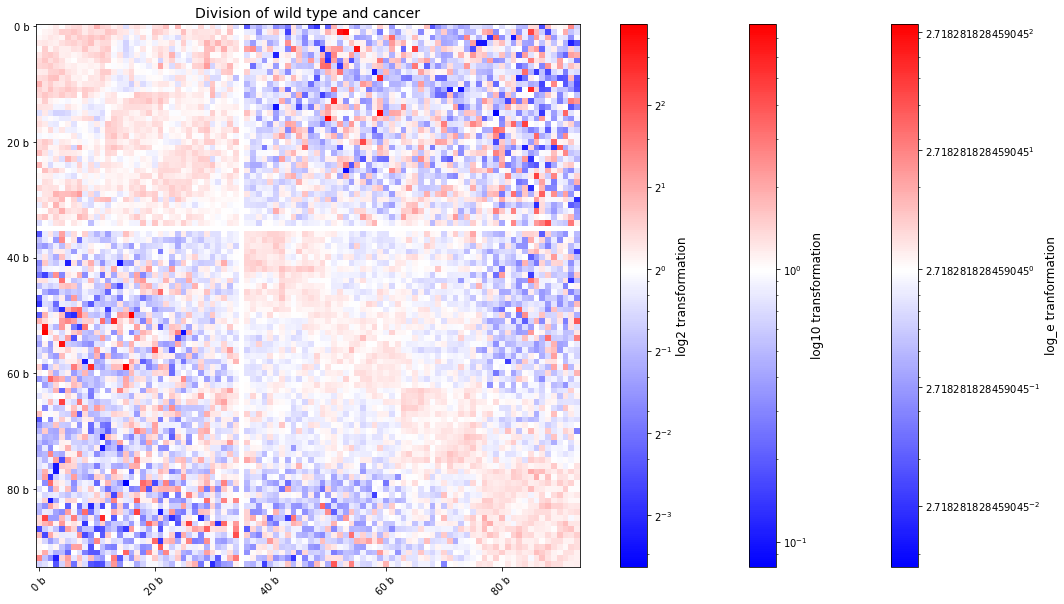

In [13]:
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, LogFormatterSciNotation

f, axs = plt.subplots(figsize=(20, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

locator10 = LogLocator(base=10)
formatter10 = LogFormatterSciNotation(base=10)

locator2 = LogLocator(base=2)
formatter2 = LogFormatterSciNotation(base=2)

locator_e = LogLocator(base=np.e)
formatter_e = LogFormatterSciNotation(base=np.e)
#norm = mcolors.LogNorm()

ax = axs
vmax = np.nanmax(abs(division_diff))
im = ax.matshow(division_diff,
                #vmax=vmax,
                #vmin=-vmax,
                norm=norm,
                cmap='bwr')
plt.colorbar(im, pad=0, label='log_e tranformation', ax=ax,
             ticks=locator_e, format=formatter_e)
plt.colorbar(im, pad=0.01, label='log10 transformation', ax=ax,
                     ticks=locator10, format=formatter10)
plt.colorbar(im,label='log2 transformation', ax=ax,
                     ticks=locator2, format=formatter2)
#cbar2.ax.yaxis.set_major_locator(locator2)
ax.set(title="Division of wild type and cancer")
format_ticks(ax)


In [14]:
print(division_diff[155, 155])

IndexError: index 155 is out of bounds for axis 0 with size 94

The base of the logarithmical transformation does not change the coloring, only the values and the ticks of the color bar changes.

## Division with pseudocount
Calculate the difference between the two interaction matrices by division with a pseudocount added, and visualize it.

In [15]:
pseudocount = 1
pseudo_div_diff = wt.divide_with_pseudocount(cancer, pseudocount=pseudocount)

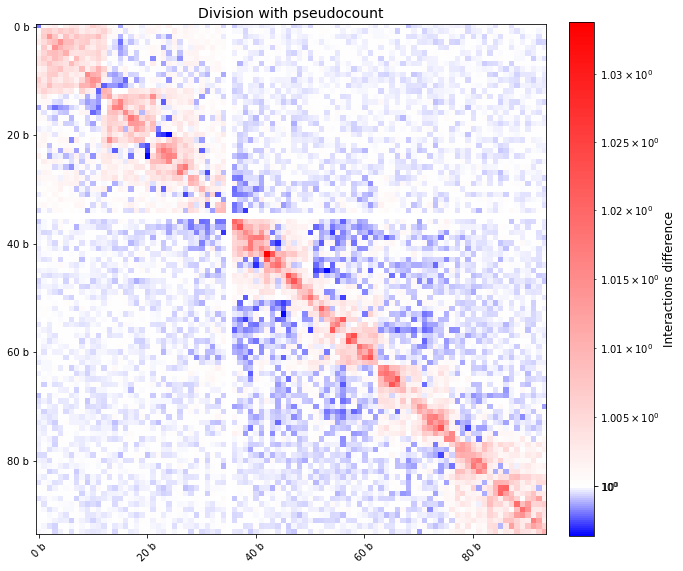

In [16]:
import matplotlib.colors as mcolors

f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)

norm = MidPointLogNorm(midpoint=1)

ax = axs
vmax = np.nanmax(abs(pseudo_div_diff))
im = ax.matshow(pseudo_div_diff,
                norm=norm,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Division with pseudocount")
format_ticks(ax)

## Relative difference
Calculate the relative difference between the two Hi-C contact matrices.

In [17]:
relative_diff = wt.relative_difference(cancer)

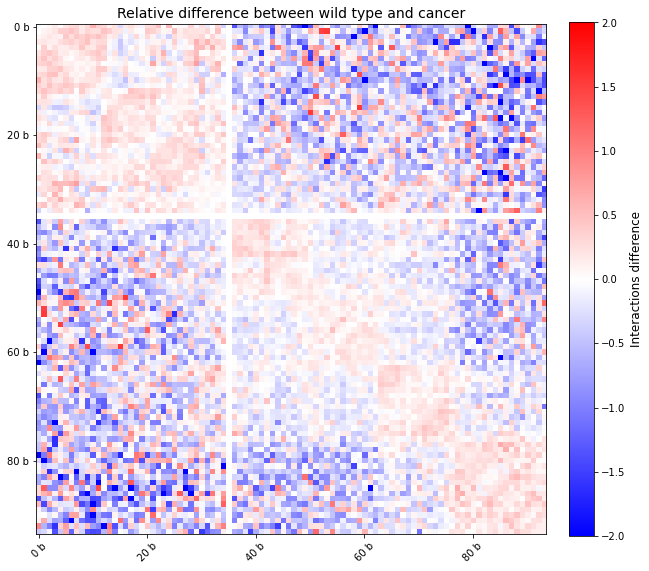

In [18]:
f, axs = plt.subplots(figsize=(10, 10),
                      nrows=1,
                      ncols=1,
                      sharex=True, sharey=False)
ax = axs
vmax = np.nanmax(abs(relative_diff))
im = ax.matshow(relative_diff,
                vmax=vmax,
                vmin=-vmax,
                cmap='bwr')
plt.colorbar(im, fraction=0.046, pad=0.04, label='Interactions difference', ax=ax)
ax.set(title="Relative difference between wild type and cancer")
format_ticks(ax)

White indicates that the interaction frequency is the same in both the wild type and the cancer data. Red colors indicates higher interaction frequency in the wild type data, whereas blue indicates higher interaction frequency in the cancer data.